## Clustering Project: Drivers of Error in Zillow Zestimates

Data Science Team Members: Gabby Broussard and Barbara Marques

#### Project Summary:

Our team has been asked to analyze Zillow data on single unit/single family properties with transaction dates in 2017 to discover the drivers of errors in Zillow's zestimates. 

Data Source: Zillow database on Codeup's data server.

#### Project Goals:
- Build out caching in your python scripts to store the data locally as a csv in order to speed up future data acquisition.
- Deliver a notebook presentation of methods used to isolate drivers of error in Zillow Zestimates

#### Initial Questions: 


<a id='back'></a>
### Quick Links to Sections within this Notebook

- [Acquire Data](#AD)
- [Prepare Data](#PD)
- [Split Data](#SD)
- [Explore Data](#Explore)
- [Hypothesis Testing](#Hypo)
- [Scale Data](#Scale)
- [Create a Baseline Model](#Baseline)
- [Model Data (train & validate)](#Model)
- [Model on Test Data](#Test)
- [Model Visualizations](#Visual)
- [Recommendations & Key Takeaways](#Concl)

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle
from acquire import get_zillow_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures


pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', 80)

<a id='AD'></a>
## Acquire
[back to top](#back)

In [3]:
acquired_zillow =get_zillow_data()

In [4]:
acquired_zillow.shape

(52519, 69)

In [5]:
acquired_zillow.describe()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror,buildingclassdesc
count,"52,519.00","52,519.00","52,519.00","13,646.00",70.00,47.00,"52,519.00","52,519.00",0.00,"33,797.00","52,368.00",390.00,"4,386.00","52,424.00","52,257.00",2.00,0.00,"4,386.00",165.00,"52,519.00","7,242.00","52,368.00","18,020.00","18,020.00","1,515.00","33,941.00","52,519.00","52,519.00","52,143.00","11,097.00",867.00,444.00,"1,071.00","10,010.00","52,519.00","52,519.00","51,482.00","52,519.00","19,042.00","52,493.00","52,519.00",47.00,"6,724.00",76.00,"33,906.00","1,938.00",65.00,"52,390.00","14,566.00",81.00,"52,434.00","52,518.00","52,519.00","52,517.00","52,515.00","2,082.00","52,396.00","52,519.00",0.00
mean,"26,259.00","1,497,295.81","12,995,228.09",2.44,7.10,678.98,2.30,3.30,nan,6.27,2.30,66.00,"1,545.78","1,922.54","1,924.72","1,180.00",nan,"1,566.52","1,241.08","6,049.13",1.21,2.24,1.95,495.69,1.00,3.97,"34,023,083.91","-118,194,356.12","11,475.45",1.00,518.32,1.00,1.00,1.00,261.00,"60,494,406.93","33,484.45","2,524.97","180,224.46","96,636.45",1.89,7.00,1.01,5.97,1.00,337.64,229.74,"1,963.43",1.41,1.00,"196,395.60","529,259.99","2,016.00","333,184.86","6,448.59",14.10,"60,502,364,233,855.30",0.02,nan
std,"15,161.07","859,396.93","3,346,502.73",3.85,2.67,711.83,1.02,0.95,nan,1.72,1.02,0.00,674.80,"1,003.89","1,003.81",169.71,nan,744.38,776.96,21.03,0.51,0.99,0.55,157.32,0.00,2.56,"274,353.69","356,745.57","86,934.14",0.00,156.47,0.00,0.00,0.00,0.08,"208,714.01","49,142.24",803.82,"159,813.91","4,601.74",3.14,0.00,0.14,0.23,0.03,249.96,190.83,23.15,0.54,0.00,"254,188.60","751,455.76",0.00,"570,199.18","8,751.05",2.39,"1,857,672,371,242.34",0.18,nan
min,0.00,349.00,"10,711,855.00",1.00,2.00,38.00,0.00,0.00,nan,1.00,1.00,66.00,184.00,128.00,128.00,"1,060.00",nan,184.00,380.00,"6,037.00",1.00,1.00,0.00,0.00,1.00,1.00,"33,340,620.00","-119,475,416.00",236.00,1.00,24.00,1.00,1.00,1.00,261.00,"60,371,011.10","3,491.00","1,286.00","6,952.00","95,982.00",0.00,7.00,1.00,4.00,1.00,11.00,12.00,"1,878.00",1.00,1.00,129.00,"1,000.00","2,016.00",161.00,49.18,4.00,"60,371,011,101,000.00",-4.66,nan
25%,"13,129.50","757,861.50","11,507,727.50",1.00,7.00,263.50,2.00,3.00,nan,5.00,2.00,66.00,"1,151.00","1,268.00","1,270.00","1,120.00",nan,"1,152.00",784.00,"6,037.00",1.00,2.00,2.00,426.00,1.00,2.00,"33,827,127.50","-118,400,864.50","5,584.00",1.00,424.50,1.00,1.00,1.00,261.00,"60,374,012.02","12,447.00","1,286.00","41,131.00","96,206.00",0.00,7.00,1.00,6.00,1.00,200.00,72.00,"1,950.00",1.00,1.00,"77,038.00","193,417.25","2,016.00","75,815.00","2,652.09",14.00,"60,374,013,031,011.00",-0.02,nan
50%,"26,259.00","1,500,862.00","12,575,721.00",1.00,7.00,512.00,2.00,3.00,nan,6.00,2.00,66.00,"1,410.00","1,658.00","1,660.00","1,180.00",nan,"1,414.00","1,008.00","6,037.00",1.00,2.00,2.00,462.00,1.00,2.00,"34,024,351.00","-118,153,319.00","6,843.00",1.00,500.00,1.00,1.00,1.00,261.00,"60,376,203.01","24,812.00","3,101.00","118,208.00","96,414.00",0.00,7.00,1.00,6.00,1.00,280.00,180.00,"1,961.00",1.00,1.00,"131,661.50","373,166.50","2,016.00","217,720.00","4,643.29",15.00,"60,376,203,014,006.00",0.01,nan
75%,"39,388.50","2

In [6]:
null_counts = acquired_zillow.isnull().sum().sort_values(ascending=False)
null_counts

finishedsquarefeet15    52519
buildingclassdesc       52519
buildingclasstypeid     52519
finishedsquarefeet13    52517
storydesc               52472
                        ...  
assessmentyear              0
logerror                    0
transactiondate             0
propertylandusedesc         0
Unnamed: 0                  0
Length: 69, dtype: int64

### Takeaways:
##### There are numerous null values that need to be handled
#### Columns with too many nulls need to be dropped from the data frame.
##### There are many outliers so they either need to be removed or handled by using a RobustScaler when scaling the data.

<a id='PD'></a>
## Prepare

[back to top](#back)

In [7]:
df= wrangle.wrangle_zillow()

In [8]:
df.head() 

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,transactiondate,heating_system,county
0,10711855,2.00,3.00,8.00,"2,107.00",6037,"34,222,559.00","-118,617,387.00","9,158.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",-0.01,2017-07-07,Central,Los_Angeles
1,10711877,2.00,4.00,8.00,"1,882.00",6037,"34,220,261.00","-118,616,409.00","9,035.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",0.02,2017-08-29,Central,Los_Angeles
2,10711888,2.00,4.00,8.00,"1,882.00",6037,"34,222,491.00","-118,616,854.00","9,800.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",0.08,2017-04-04,Central,Los_Angeles
3,10711910,2.00,3.00,8.00,"1,477.00",6037,"34,221,864.00","-118,615,739.00","11,285.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",-0.04,2017-03-17,Central,Los_Angeles
4,10711923,2.00,4.00,8.00,"1,918.00",6037,"34,220,619.00","-118,615,253.00","11,239.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",-0.01,2017-03-24,Central,Los_Angeles


In [9]:
# look at the first 5 rows of our new dataframe, transposed
df.head().T

,0,1,2,3,4
parcelid,10711855,10711877,10711888,10711910,10711923
bathrooms,2.00,2.00,2.00,2.00,2.00
bedrooms,3.00,4.00,4.00,3.00,4.00
buildingquality,8.00,8.00,8.00,8.00,8.00
square_feet,"2,107.00","1,882.00","1,882.00","1,477.00","1,918.00"
fips,6037,6037,6037,6037,6037
latitude,"34,222,559.00","34,220,261.00","34,222,491.00","34,221,864.00","34,220,619.00"
longitude,"-118,617,387.00","-118,616,409.00","-118,616,854.00","-118,615,739.00","-118,615,253.00"
lot_size,"9,158.00","9,035.00","9,800.00","11,285.00","11,239.00"
regionidcity,"12,447.00","12,447.00","12,447.00","12,447.00","12,447.00"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50935 entries, 0 to 52504
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parcelid             50935 non-null  int64  
 1   bathrooms            50935 non-null  float64
 2   bedrooms             50935 non-null  float64
 3   buildingquality      50935 non-null  float64
 4   square_feet          50935 non-null  float64
 5   fips                 50935 non-null  int64  
 6   latitude             50935 non-null  float64
 7   longitude            50935 non-null  float64
 8   lot_size             50935 non-null  float64
 9   regionidcity         50935 non-null  float64
 10  regionidcounty       50935 non-null  float64
 11  regionidzip          50935 non-null  float64
 12  roomcnt              50935 non-null  float64
 13  unit_count           50935 non-null  float64
 14  age                  50935 non-null  float64
 15  structure_tax_value  50935 non-null 

In [11]:
#There are no remaining null values

df.isna().sum().sum()

0

### Creating some new features:
- bins for: age, square feet
- tax rate
- bath/bed ratio:  (bathroom count / bedroom count)
- acres (lotsizesquarefeet/43560)
- dollar per square foot
- within city of Los Angeles


In [12]:
def create_features(df):
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.tax_value*100

    # create acres variable
    df['acres'] = df.lot_size/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.square_feet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structure_tax_value/df.square_feet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.land_tax_value/df.lot_size

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathrooms/df.bedrooms

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df


In [13]:
create_features(df)

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,transactiondate,heating_system,county,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,10711855,2.00,3.00,8.00,"2,107.00",6037,"34,222,559.00","-118,617,387.00","9,158.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",-0.01,2017-07-07,Central,Los_Angeles,0.33,1.23,0.21,0.20,0.50,118.49,0.40,40.89,0.30,0.67,1
1,10711877,2.00,4.00,8.00,"1,882.00",6037,"34,220,261.00","-118,616,409.00","9,035.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",0.02,2017-08-29,Central,Los_Angeles,0.33,1.23,0.21,0.20,0.40,134.43,0.40,45.05,0.30,0.50,1
2,10711888,2.00,4.00,8.00,"1,882.00",6037,"34,222,491.00","-118,616,854.00","9,800.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",0.08,2017-04-04,Central,Los_Angeles,0.33,1.23,0.22,0.20,0.40,136.87,0.40,29.12,0.30,0.50,1
3,10711910,2.00,3.00,8.00,"1,477.00",6037,"34,221,864.00","-118,615,739.00","11,285.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",-0.04,2017-03-17,Central,Los_Angeles,0.40,1.43,0.26,0.30,0.30,39.25,0.10,1.78,0.10,0.67,1
4,10711923,2.00,4.00,8.00,"1,918.00",6037,"34,220,619.00","-118,615,253.00","11,239.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",-0.01,2017-03-24,Central,Los_Angeles,0.40,1.26,0.26,0.30,0.40,87.52,0.30,22.03,0.30,0.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,17300863,5.50,5.00,6.00,"4,983.00",6111,"34,199,005.00","-118,676,447.00","32,226.00","42,091.00","2,061.00","96,342.00",9.00,1.00,16.00,"865,487.00","1,538,389.00","2,016.00","672,902.00","17,404.54",0.06,2017-06-16,None,Ventura,0.13,1.13,0.74,0.40,0.80,173.69,0.50,20.88,0.30,1.10,0
52501,162960516,2.50,3.00,6.00,"1,449.00",6111,"34,273,914.00","-119,164,501.00","6,926.00","34,543.00","2,061.00","97,084.00",5.00,1.00,31.00,"288,913.00","481,521.00","2,016.00","192,608.00","5,063.30",0.02,2017-05-08,None,Ventura,0.27,1.05,0.16,0.20,0.30,199.39,0.50,27.81,0.30,0.83,0
52502,162960529,4.00,4.00,6.00,"2,459.00",6111,"34,245,590.00","-119,169,692.00","5,400.00","13,150.00","2,061.00","97,107.00",7.00,1.00,10.00,"169,000.00","479,000.00","2,016.00","310,000.00","12,285.88",0.01,2017-05-26,None,Ventura,0.07,2.56,0.12,0.10,0.50,68.73,0.20,57.41,0.40,1.00,0
52503,162960596,2.00,4.00,6.00,"1,379.00",6111,"34,219,587.00","-119,042,663.00","7,343.00","51,239.00","2,061.00","97,089.00",7.00,1.00,57.00,"224,567.00","449,134.00","2,016.00","224,567.00","4,787.16",0.03,2017-07-18,None,Ventura,0.40,1.07,0.17,0.20,0.30,162.85,0.50,30.58,0.30,0.50,0


In [14]:
df.head().T

,0,1,2,3,4
parcelid,10711855,10711877,10711888,10711910,10711923
bathrooms,2.00,2.00,2.00,2.00,2.00
bedrooms,3.00,4.00,4.00,3.00,4.00
buildingquality,8.00,8.00,8.00,8.00,8.00
square_feet,"2,107.00","1,882.00","1,882.00","1,477.00","1,918.00"
fips,6037,6037,6037,6037,6037
latitude,"34,222,559.00","34,220,261.00","34,222,491.00","34,221,864.00","34,220,619.00"
longitude,"-118,617,387.00","-118,616,409.00","-118,616,854.00","-118,615,739.00","-118,615,253.00"
lot_size,"9,158.00","9,035.00","9,800.00","11,285.00","11,239.00"
regionidcity,"12,447.00","12,447.00","12,447.00","12,447.00","12,447.00"


In [15]:
df.describe()

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft
count,"50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00","50,935.00"
mean,"12,960,871.10",2.28,3.30,6.16,"1,897.63","6,049.20","34,021,885.12","-118,193,492.31","11,115.58","33,535.67","2,524.61","96,640.41",1.92,1.00,53.85,"186,702.54","497,037.64","2,016.00","310,335.09","6,064.32",0.02,1.33,0.26,89.46,47.24
std,"2,191,590.84",0.98,0.92,1.37,933.63,21.13,"272,983.62","355,577.07","87,362.30","49,261.40",803.41,"4,671.11",3.16,0.00,22.89,"198,603.18","510,491.97",0.00,"363,809.25","5,926.08",0.17,0.56,2.01,56.41,65.89
min,"10,711,855.00",1.00,1.00,1.00,500.00,"6,037.00","33,340,620.00","-119,475,265.00",236.00,"3,491.00","1,286.00","95,982.00",0.00,1.00,1.00,148.00,"3,254.00","2,016.00",161.00,49.18,-4.66,0.01,0.01,0.04,0.00
25%,"11,516,493.50",2.00,3.00,6.00,"1,266.00","6,037.00","33,827,379.50","-118,396,780.50","5,590.00","12,447.00","1,286.00","96,206.00",0.00,1.00,39.00,"76,794.00","191,426.50","2,016.00","73,824.00","2,630.52",-0.02,1.16,0.13,54.60,9.24
50%,"12,589,489.00",2.00,3.00,6.00,"1,650.00","6,037.00","34,021,131.00","-118,151,743.00","6,838.00","24,812.00","3,101.00","96,415.00",0.00,1.00,57.00,"130,233.00","369,000.00","2,016.00","215,640.00","4,592.45",0.01,1.23,0.16,81.53,30.18
75%,"14,130,968.00",3.00,4.00,7.00,"2,279.00","6,059.00","34,186,065.50","-117,929,429.00","8,702.00","40,227.00","3,101.00","96,996.00",5.00,1.00,67.00,"220,917.00","609,150.00","2,016.00","404,652.00","7,240.22",0.04,1.37,0.20,112.42,59.59
max,"162,960,814.00",10.00,11.00,12.00,"12,039.00","6,111.00","34,818,767.00","-117,572,338.00","6,971,010.00","396,556.00","3,101.00","399,675.00",14.00,1.00,139.00,"3,348,387.00","4,993,132.00","2,016.00","4,847,224.00","142,488.69",3.39,49.36,160.03,"1,444.22","1,604.53"


(array([2.0000e+00, 0.0000e+00, 1.4000e+01, 1.6000e+01, 1.1200e+02,
        4.8003e+04, 2.5950e+03, 1.0000e+02, 8.3000e+01, 1.0000e+01]),
 array([-4.65542038, -3.85042393, -3.04542749, -2.24043104, -1.4354346 ,
        -0.63043816,  0.17455829,  0.97955473,  1.78455118,  2.58954762,
         3.39454407]),
 <BarContainer object of 10 artists>)

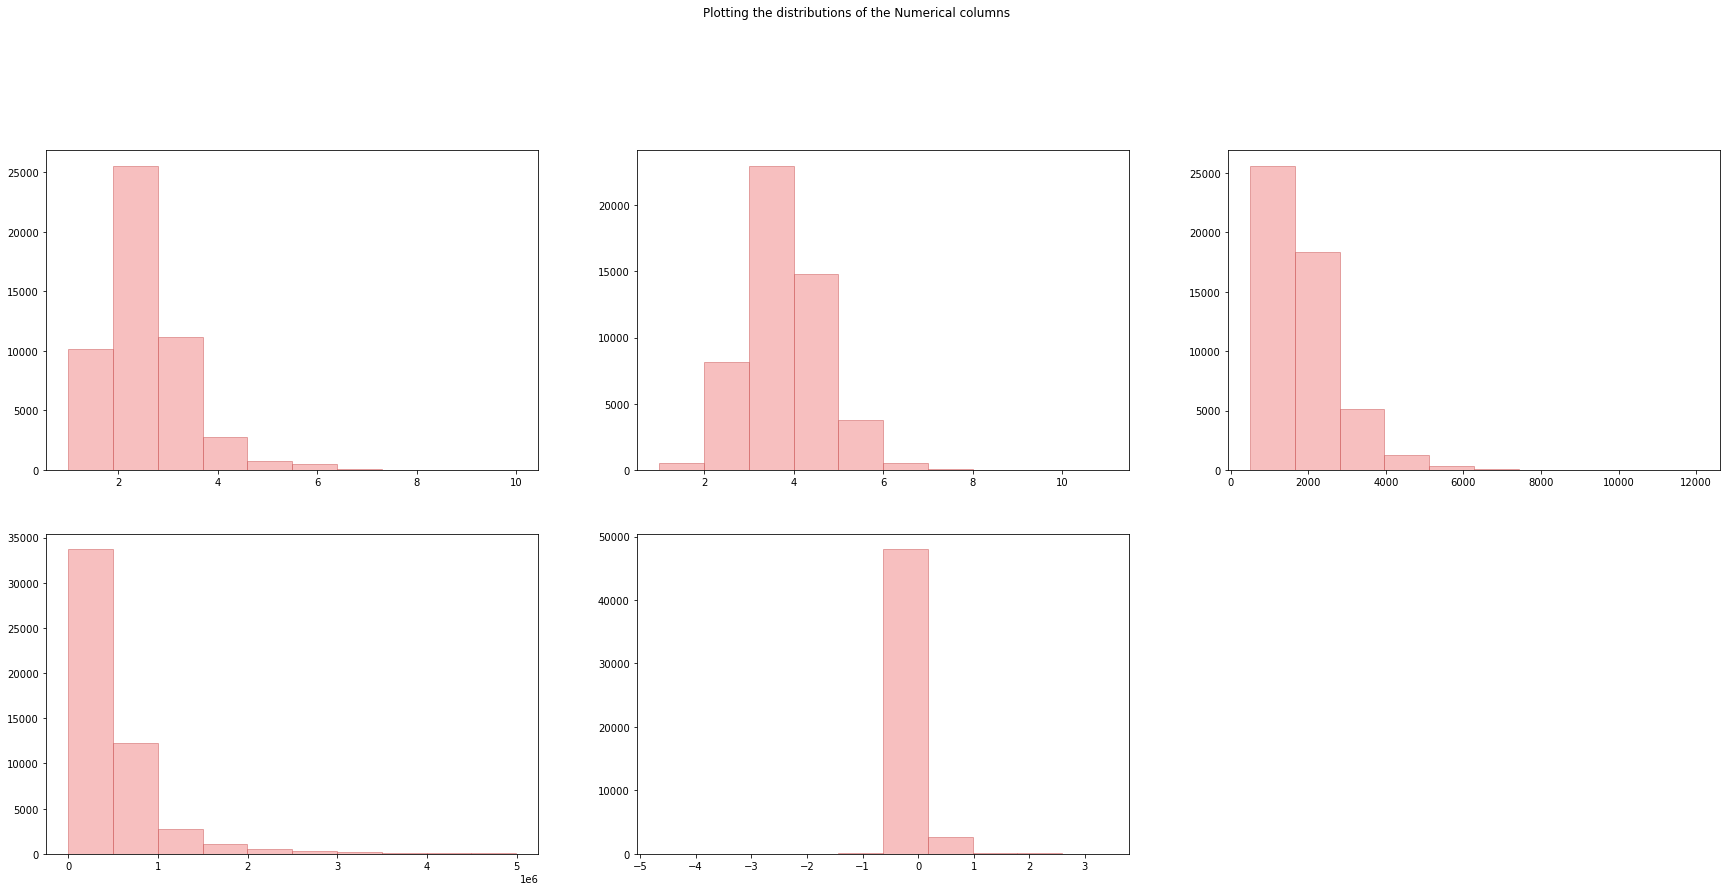

In [16]:
plt.figure(figsize=(30, 20))

plt.suptitle("Plotting the distributions of the Numerical columns")
# row, columns, index
plt.subplot(3, 3, 1)
plt.hist(df.bathrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 2)
plt.hist(df.bedrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 3)
plt.hist(df.square_feet, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 4)
plt.hist(df.tax_value, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 5)
plt.hist(df.logerror, edgecolor='indianred', alpha=0.5, color='lightcoral')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50935 entries, 0 to 52504
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   parcelid                   50935 non-null  int64   
 1   bathrooms                  50935 non-null  float64 
 2   bedrooms                   50935 non-null  float64 
 3   buildingquality            50935 non-null  float64 
 4   square_feet                50935 non-null  float64 
 5   fips                       50935 non-null  int64   
 6   latitude                   50935 non-null  float64 
 7   longitude                  50935 non-null  float64 
 8   lot_size                   50935 non-null  float64 
 9   regionidcity               50935 non-null  float64 
 10  regionidcounty             50935 non-null  float64 
 11  regionidzip                50935 non-null  float64 
 12  roomcnt                    50935 non-null  float64 
 13  unit_count                 5093

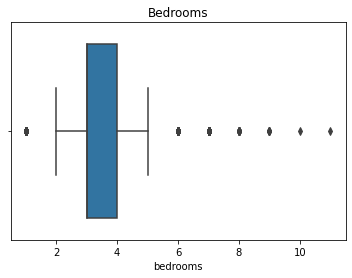

In [18]:
### Checking for Outliers:
sns.boxplot(df['bedrooms'])
plt.title('Bedrooms')
plt.show()

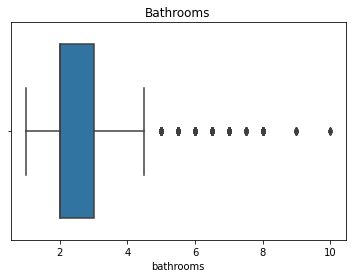

In [19]:
sns.boxplot(df['bathrooms'])
plt.title('Bathrooms')
plt.show()

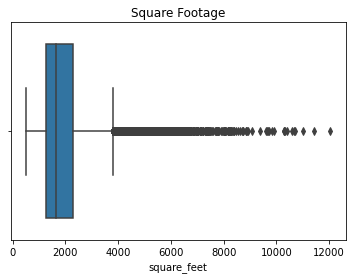

In [20]:
sns.boxplot(df['square_feet'])
plt.title('Square Footage')
plt.show()

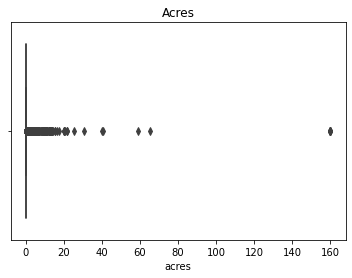

In [21]:
sns.boxplot(df['acres'])
plt.title('Acres')
plt.show()

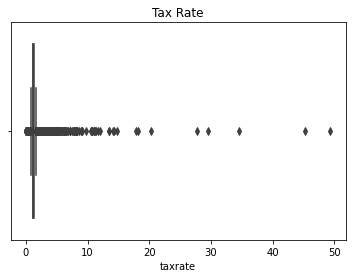

In [22]:
sns.boxplot(df['taxrate'])
plt.title('Tax Rate')
plt.show()

### Takeaways:  

Removing Outliers:

Remove extremes in bedrooms and baths (KEEP only 1-7 baths and 1-7 bedrooms)

remove square feet > 9000

remove lot size (acres) > 20 

Remove tax rate > 10% 

In [30]:
def remove_outliers(df):
    '''
    remove outliers in bed, bath, square feet, acres & tax rate
    '''

    return df[((df.bathrooms <= 7) & (df.bedrooms <= 7) &
               (df.bathrooms >= 1) & 
               (df.bedrooms >= 1) & 
               (df.acres <= 20) &
               (df.square_feet <= 9000) & 
               (df.taxrate <= 10)
              )]

In [31]:
df = remove_outliers(df)
df.head()

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,transactiondate,heating_system,county,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin
0,10711855,2.00,3.00,8.00,"2,107.00",6037,"34,222,559.00","-118,617,387.00","9,158.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",-0.01,2017-07-07,Central,Los_Angeles,0.33,1.23,0.21,0.20,0.50,118.49,0.40,40.89,0.30
1,10711877,2.00,4.00,8.00,"1,882.00",6037,"34,220,261.00","-118,616,409.00","9,035.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",0.02,2017-08-29,Central,Los_Angeles,0.33,1.23,0.21,0.20,0.40,134.43,0.40,45.05,0.30
2,10711888,2.00,4.00,8.00,"1,882.00",6037,"34,222,491.00","-118,616,854.00","9,800.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",0.08,2017-04-04,Central,Los_Angeles,0.33,1.23,0.22,0.20,0.40,136.87,0.40,29.12,0.30
3,10711910,2.00,3.00,8.00,"1,477.00",6037,"34,221,864.00","-118,615,739.00","11,285.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",-0.04,2017-03-17,Central,Los_Angeles,0.40,1.43,0.26,0.30,0.30,39.25,0.10,1.78,0.10
4,10711923,2.00,4.00,8.00,"1,918.00",6037,"34,220,619.00","-118,615,253.00","11,239.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",-0.01,2017-03-24,Central,Los_Angeles,0.40,1.26,0.26,0.30,0.40,87.52,0.30,22.03,0.30


In [32]:
df.shape

(50819, 33)

<a id='SD'></a>
#### Splitting Data

[back to top](#back)

In [33]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.data_split(df,stratify_by='logerror')

In [34]:
X_train.shape, X_validate.shape, X_test.shape

((28458, 32), (12197, 32), (10164, 32))

In [35]:
y_train.shape, y_validate.shape, y_test.shape

((28458,), (12197,), (10164,))

In [36]:
train_validate, test = train_test_split(df, test_size=.30, random_state=123)
train, validate = train_test_split(train_validate, test_size=.20, random_state=123)

print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  939114
validate observations:  234795
test observations:  503118


In [44]:
y_train = pd.DataFrame(y_train)
y_train

,logerror
41364,0.02
32738,-0.01
707,0.10
30071,0.09
27720,-0.03
...,...
201,0.03
48220,0.11
26489,-0.10
3575,-0.08


### <font color = 'red'>  ???? I'm confused about the observation counts on in cell directly above -- There should be a TOTAL of 50,819 observations

### Takeaways:
##### Dropped unneeded columns
##### Renamed columns to make easier to call
##### Created new features
##### Identified and removed outliers
##### Binned some variables to aid in exploration
##### Split data and scaled data
##### Data is ready for exploration


<a id='Explore'></a>
## Explore

[back to top](#back)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28458 entries, 41364 to 42732
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   parcelid                   28458 non-null  int64   
 1   bathrooms                  28458 non-null  float64 
 2   bedrooms                   28458 non-null  float64 
 3   buildingquality            28458 non-null  float64 
 4   square_feet                28458 non-null  float64 
 5   fips                       28458 non-null  int64   
 6   latitude                   28458 non-null  float64 
 7   longitude                  28458 non-null  float64 
 8   lot_size                   28458 non-null  float64 
 9   regionidcity               28458 non-null  float64 
 10  regionidcounty             28458 non-null  float64 
 11  regionidzip                28458 non-null  float64 
 12  roomcnt                    28458 non-null  float64 
 13  unit_count                 

#### Correlation Test: square feet/log error  <br>
𝐻0: There is no difference in log error based on a properties square footage. <font color = 'red'>  --> REJECTED  <font color = 'black'>
    
𝐻𝑎: Properties with a square footage less than 2800 square footage have a lower log error than larger properties. 

In [45]:
α = .05

x = X_train.square_feet
y = y_train.logerror

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no difference in log error based on a properties square footage.")
else:
    print("We fail to reject the null hypothesis")

'r' correlation coefficient is 0.03656900596871775
p-value (probability of seeing the data given the null hypothesis is true) is  6.794488946994873e-10
We reject the null hypothesis that there is no difference in log error based on a properties square footage.


#### Correlation Test: age/log error  <br>
𝐻0 : There is no difference in median log error in properties built in different years. <font color = 'red'>  --> REJECTED  <font color = 'black'>
    
𝐻𝑎 : Properties that were built after 1975 have a higher median log error than properties built before 1975.
<br><br>

In [47]:
α = .05

x = X_train.age
y = y_train.logerror

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no difference in log error based on a home's age.")
else:
    print("We fail to reject the null hypothesis")

'r' correlation coefficient is -0.02144078340490189
p-value (probability of seeing the data given the null hypothesis is true) is  0.000297796079538452
We reject the null hypothesis that there is no difference in log error based on a home's age.


#### Correlation Test: latitude/log error 

𝐻0 : There is no correlation between latitude and log error. <font color = 'red'>  --> REJECTED  <font color = 'black'>

𝐻𝑎 : Properties that are more southern have a higher log error.


In [49]:
α = .05

x = X_train.latitude
y = y_train.logerror

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no difference in log error based on a home's latitude.")
else:
    print("We fail to reject the null hypothesis")

'r' correlation coefficient is -0.023547632085190603
p-value (probability of seeing the data given the null hypothesis is true) is  7.104942590256166e-05
We reject the null hypothesis that there is no difference in log error based on a home's latitude.


In [ ]:
### Drop Columns not needed



<a id='Scale'></a>
### Scale Data

[back to top](#back)

<a id='Model'></a>

## Model

[back to top](#back)

<a id='Concl'></a>

## Conclusion

[back to top](#back)